In [106]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import CategoricalNB, GaussianNB
import warnings
import time
warnings.filterwarnings('ignore')

### Загрузка датасета и вывод инфориации о нем

In [58]:
df = pd.read_csv('categ.csv').drop('Unnamed: 0', axis=1)

In [4]:
df

,размер,ткань,цвет,рукав,спрос
0,S,нейлон,белый,длинный,средний
1,XL,полиэстр,кремовый,короткий,высокий
2,S,шёлк,голубой,короткий,средний
3,M,хлопок,чёрный,короткий,средний
4,XL,полиэстр,оранжевый,длинный,средний
...,...,...,...,...,...
9995,M,нейлон,чёрный,длинный,средний
9996,L,хлопок,белый,длинный,высокий
9997,XXL,нейлон,чёрный,длинный,средний
9998,S,лён,белый,длинный,высокий


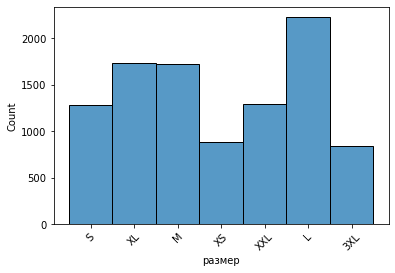

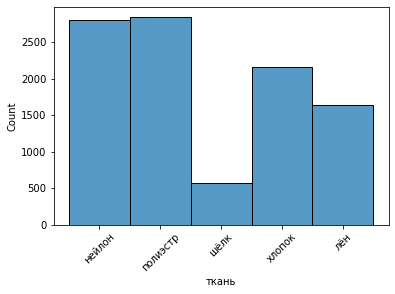

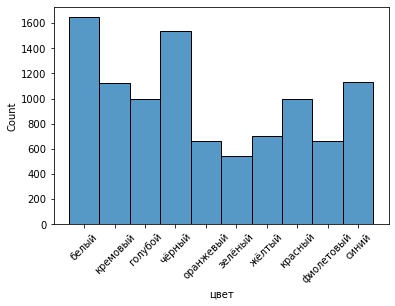

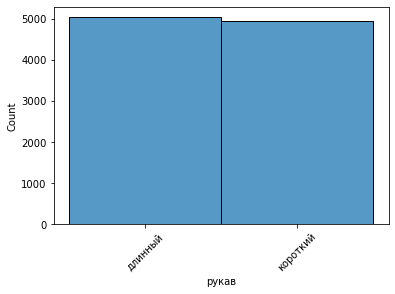

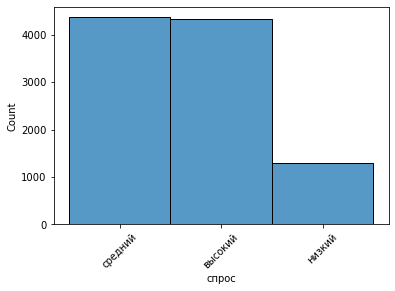

In [5]:
for col in df.columns:
    sns.histplot(df[col])
    plt.xticks(rotation=45)
    plt.show()

In [6]:
df.describe().T

,count,unique,top,freq
размер,10000,7,L,2231
ткань,10000,5,полиэстр,2840
цвет,10000,10,белый,1646
рукав,10000,2,длинный,5044
спрос,10000,3,средний,4368


## Создание класса модели Наивного Байеса

In [7]:
class MyCategoricalNB:
    classes = None

    def fit(self, data, label):
        self.classes = label.unique()
        data['label'] = label
        self.simple_prob = pd.Series(*np.unique(data, return_counts=True)[::-1])
        self.simple_prob /= label.shape[0]
        self.hard_prob = pd.DataFrame({col: data.groupby(['label', col]).count().iloc[:,0] / data.groupby('label').count().iloc[:,0]
                          for col in data.drop('label', axis=1).columns})
        return self

    def predict_one(self, one):
        bayes_denom = np.prod(self.simple_prob[one])

        get_brob_character = lambda index, class_: self.hard_prob[index[0]][class_].get(one[index[0]], default=0)
        get_prob_class = lambda class_: np.prod(np.apply_along_axis(get_brob_character, 1, one.index.to_numpy()[:, np.newaxis], class_[0])) \
                                        * self.simple_prob[class_[0]] / bayes_denom

        return np.apply_along_axis(get_prob_class, 1, self.classes[:, np.newaxis])

    def prob_predict(self, data):
        data = data.T.apply(self.predict_one).T
        data.columns = self.classes
        return data

    def predict(self, data):
        return self.classes[self.prob_predict(data).T.apply(np.argmax).to_numpy()]

In [8]:
X, y = df.drop('спрос', axis=1), df['спрос']

### Кроссвалидация

In [9]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)
for train_index, test_index in rskf.split(X, y):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    cnb = MyCategoricalNB()
    y_pred = cnb.fit(X_train, y_train).predict(X_test)
    print(accuracy_score(y_test, y_pred))

0.824
0.789
0.82
0.805
0.818
0.834
0.817
0.807
0.834
0.792
0.799
0.806
0.817
0.816
0.802
0.813
0.829
0.806
0.799
0.825
0.795
0.821
0.819
0.825
0.81
0.817
0.819
0.823
0.81
0.813
0.828
0.806
0.804
0.824
0.81
0.822
0.808
0.809
0.792
0.832
0.808
0.823
0.816
0.826
0.819
0.801
0.812
0.802
0.819
0.831


### Обучение модели

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [47]:
cnb = MyCategoricalNB()

In [48]:
cnb.fit(X_train, y_train)

In [86]:
y_pred = cnb.predict(X_test)

### Тесты скорости самописной модели

In [152]:
%%time
y_pred_prob = cnb.prob_predict(X_test)

CPU times: total: 4.75 s
Wall time: 4.73 s


In [153]:
%%time
y_pred = cnb.predict(X_test)

CPU times: total: 4.78 s
Wall time: 4.81 s


### Проверка точности самописной модели

In [50]:
accuracy_score(y_test, y_pred)

0.8192

<AxesSubplot:>

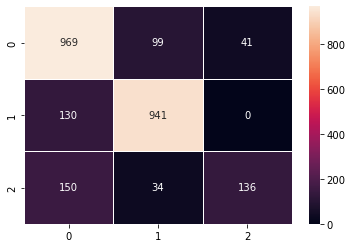

In [92]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, linewidths=1, fmt='')

## Использование встроенного класса Наивного Баяса

In [63]:
cnb_build_in = CategoricalNB()

### Обучение молдели

In [64]:
cnb_build_in.fit(X_train, y_train)

CategoricalNB()

In [65]:
y_pred = cnb_build_in.predict(X_test)

### Проверка точности модели

In [66]:
accuracy_score(y_test, y_pred)

0.8184

<AxesSubplot:>

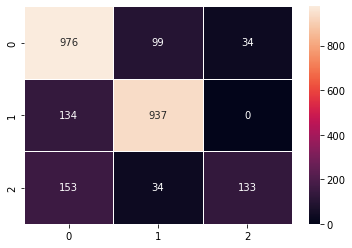

In [83]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, linewidths=1, fmt='')

## Использование встроенного класса Наивного Байеса на встроенных датасетах

### Загрузка данных

In [93]:
from sklearn.datasets import load_iris, load_wine, load_digits, load_breast_cancer

In [128]:
X, y = load_iris(return_X_y=True)

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [130]:
model = GaussianNB()
y_pred = model.fit(X_train, y_train).predict(X_test)

In [131]:
accuracy_score(y_test, y_pred)

0.9736842105263158

<AxesSubplot:>

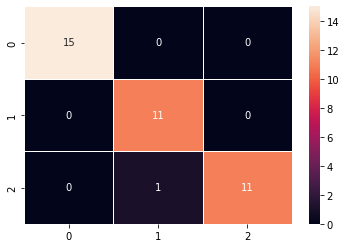

In [132]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, linewidths=1, fmt='')